<a href="https://colab.research.google.com/github/lineality/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3/GGA_2_1_3_v4_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling
2.1.3
Geoffrey Gordon Ashbrook DS8


# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

Assignment Goals:
- [ ] 1. Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] 2. Do one-hot encoding of categorical features.
- [ ] 3. Do feature selection with `SelectKBest`.
- [ ] 4. Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] 5. Fit a ridge regression model with multiple features.
- [ ] 6. Get mean absolute error for the test set.
- [ ] 7. As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [425]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

#Inspecting Data

In [430]:
df.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [431]:
df.shape

(23040, 21)

In [432]:
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

## Cleaning Part 1

In [0]:
# using "masks"
#condition = (('BUILDING_CLASS_CATEGORY' == '01 ONE FAMILY DWELLINGS') &
#      (df['SALE_PRICE'] > 100000) &
#      (df['SALE_PRICE'] < 2000000))
#subset = df.loc[condition]
#print(subset.head())  

In [0]:
# filtering dataframe using "masks" and .loc
price_mask = (df['SALE_PRICE'] > 1_000_000) & (df['SALE_PRICE'] < 2_000_000_000)
house_mask = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')
df = df.loc[price_mask]
df = df.loc[house_mask]

In [0]:
df = df.drop(columns = 'EASE-MENT')
df = df.drop(columns = 'APARTMENT_NUMBER')
#df = df.drop(columns = 'SALE_DATE')
df = df.drop(columns = 'NEIGHBORHOOD')

In [0]:
# First, remove the comma separator, then cast to float
df["LAND_SQUARE_FEET"] = df["LAND_SQUARE_FEET"].str.replace(",", "").astype(float)

In [0]:
df = df.dropna()

In [438]:
df.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.0,3.360000e+02
mean,4797.369048,70.619048,11095.172619,1.002976,0.077381,1.080357,4160.988095,2552.348214,1933.961310,1.0,2.224985e+06
std,3067.536616,217.190206,432.769236,0.054554,0.289044,0.293361,2986.684085,1409.844090,28.944233,0.0,2.885639e+06
min,97.000000,1.000000,10009.000000,1.000000,0.000000,1.000000,345.000000,100.000000,1899.000000,1.0,1.015000e+06
25%,1765.000000,19.000000,11209.000000,1.000000,0.000000,1.000000,2000.000000,1764.750000,1915.000000,1.0,1.169500e+06
50%,5264.500000,44.000000,11228.000000,1.000000,0.000000,1.000000,3358.000000,2184.000000,1930.000000,1.0,1.425000e+06
75%,6793.750000,65.250000,11362.000000,1.000000,0.000000,1.000000,5325.000000,3000.250000,1945.000000,1.0,1.915625e+06
max,16319.000000,2780.000000,11694.000000,2.000000,2.000000,3.000000,18906.000000,11224.000000,2018.000000,1.0,3.013936e+07


In [439]:
# This tells you how many different non-numeric variables there are, e.g. if they are binary or nearly so.
# different summary
# Describes non-numeric collumns
df.describe(exclude='number') 

,BOROUGH,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,336,336,336,336,336,336,336
unique,5,1,1,11,335,10,82
top,3,01 ONE FAMILY DWELLINGS,1,A1,750 WEST 232 STREET,A1,01/17/2019
freq,142,336,336,137,2,138,16


Note: it looks like today's dataset might need to be cleaned a bit...

Note: The ease-ment feature seems to be entirely empty.

#GGA CODE Begins Here

In [440]:
df.head(2)

,BOROUGH,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
120,3,01 ONE FAMILY DWELLINGS,1,6806,72,A1,1747 EAST 23RD STREET,11229.0,1.0,0.0,1.0,4000.0,1932.0,1930.0,1,A1,1150000,01/02/2019
160,4,01 ONE FAMILY DWELLINGS,1,3317,24,A3,80-46 GRENFELL STREET,11415.0,1.0,0.0,1.0,7000.0,3203.0,1920.0,1,A3,1390000,01/02/2019


##Cleaning

In [0]:
#not working
#the feature square feet is not showing up as numeric
#df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].astype(int)

In [442]:
#exploring the data
pandas_profiling.ProfileReport(df)

##Make Test Train Split Using Time
##Goal 1

Blurb:
Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test



In [0]:

# create a test train split 
# remember to put time in quotes
df["SALE_DATE"] = pd.to_datetime(df["SALE_DATE"], infer_datetime_format=True)
train = df[df['SALE_DATE'] < '2019-04-01 00:00:00']
test = df[df['SALE_DATE'] >= '2019-04-01 00:00:00']

## One Hot Encoding
## Goal 2

Step 1: remove rows that have high cardonality

In [444]:
df.describe(exclude='number') 

,BOROUGH,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,336,336,336,336,336,336,336
unique,5,1,1,11,335,10,82
top,3,01 ONE FAMILY DWELLINGS,1,A1,750 WEST 232 STREET,A1,2019-01-17 00:00:00
freq,142,336,336,137,2,138,16
first,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-02 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS',	
                    #'LAND_SQUARE_FEET',	
                    #'BUILDING_CLASS_AT_TIME_OF_SALE',	
                    'SALE_DATE']

#                    ['BUILDING_CLASS_CATEGORY', 
#                    'BUILDING_CLASS_AT_PRESENT', 
#                    'ADDRESS', 
#                    'LAND_SQUARE_FEET',
#                    'BUILDING_CLASS_AT_TIME_OF_SALE',
#                    'SALE_DATE']
				
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [447]:
#looking at data
X_train.head(3)

,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_1,BOROUGH_2,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_S0,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S0
120,1,0,0,0,0,1,1,6806,72,1,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,4000.0,1932.0,1930.0,1,1,0,0,0,0,0,0,0,0,0
160,0,1,0,0,0,1,1,3317,24,0,1,0,0,0,0,0,0,0,0,11415.0,1.0,0.0,1.0,7000.0,3203.0,1920.0,1,0,1,0,0,0,0,0,0,0,0
191,0,0,1,0,0,1,1,894,155,0,1,0,0,0,0,0,0,0,0,10304.0,1.0,0.0,1.0,9927.0,5048.0,2004.0,1,0,1,0,0,0,0,0,0,0,0


## Feature Selection, featuring our show's favorite guest: SelectKBest!
## Goal 3

In [461]:
# Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)
from sklearn.feature_selection import f_regression, SelectKBest

# Similar API to what we've seen before
selector = SelectKBest(score_func=f_regression, k=10)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((268, 10), (68, 10))

In [462]:
# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_4
BOROUGH_1
BLOCK
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A4
ZIP_CODE
GROSS_SQUARE_FEET
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A4


Features not selected:
BOROUGH_3
BOROUGH_5
BOROUGH_2
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
LOT
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_A7
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_S0
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A7
BUILDING_CLASS_AT_TIME_OF_SALE_A2
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_S0


In [463]:
# How many features should be selected?
# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $812,448 

2 features
Test MAE: $749,556 

3 features
Test MAE: $763,308 

4 features
Test MAE: $737,830 

5 features
Test MAE: $737,830 

6 features
Test MAE: $741,002 

7 features
Test MAE: $731,930 

8 features
Test MAE: $732,796 

9 features
Test MAE: $732,392 

10 features
Test MAE: $727,133 

11 features
Test MAE: $651,691 

12 features
Test MAE: $690,499 

13 features
Test MAE: $683,129 

14 features
Test MAE: $736,947 

15 features
Test MAE: $751,379 

16 features
Test MAE: $751,379 

17 features
Test MAE: $754,420 

18 features
Test MAE: $759,441 

19 features
Test MAE: $758,572 

20 features
Test MAE: $754,701 

21 features
Test MAE: $750,652 

22 features
Test MAE: $750,652 

23 features
Test MAE: $785,263 

24 features
Test MAE: $785,263 

25 features
Test MAE: $786,335 

26 features
Test MAE: $786,335 

27 features
Test MAE: $789,145 

28 features
Test MAE: $789,145 

29 features
Test MAE: $789,145 

30 features
Test MAE: $789,145 

31 features
Test MA

In [464]:
# Correlation matrix!
X_train.corr()

,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_1,BOROUGH_2,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_S0,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S0
BOROUGH_3,1.000000,-0.701554,-0.234058,-0.247063,-0.138764,NaN,NaN,0.088586,-0.063548,-0.045679,-0.195353,0.072227,-0.107579,0.253567,0.107081,0.063443,-0.046013,-0.090154,0.014432,0.242151,NaN,-0.030065,-0.030065,-0.379303,-0.166872,-0.358013,NaN,-0.045679,-0.195353,0.072227,-0.107579,0.253567,0.107081,0.063443,-0.046013,-0.090154,0.014432
BOROUGH_4,-0.701554,1.000000,-0.228714,-0.241421,-0.135595,NaN,NaN,0.184889,-0.088512,0.158451,0.023076,-0.050671,0.161900,-0.199447,-0.293959,0.049564,0.020609,0.128506,-0.071794,0.501126,NaN,-0.023961,-0.023961,0.220339,-0.158571,0.239646,NaN,0.158451,0.023076,-0.050671,0.161900,-0.199447,-0.293959,0.049564,0.020609,0.128506,-0.071794
BOROUGH_5,-0.234058,-0.228714,1.000000,-0.080545,-0.045238,NaN,NaN,-0.164782,0.016304,0.005955,0.346643,-0.016905,-0.004012,-0.084637,-0.098073,-0.105295,-0.074121,-0.029391,-0.023953,-0.510231,NaN,-0.075471,-0.075471,0.460797,0.220097,0.498620,NaN,0.005955,0.346643,-0.016905,-0.004012,-0.084637,-0.098073,-0.105295,-0.074121,-0.029391,-0.023953
BOROUGH_1,-0.247063,-0.241421,-0.080545,1.000000,-0.047752,NaN,NaN,-0.341899,-0.011380,-0.243293,-0.107369,-0.017845,-0.070998,0.009803,0.468972,-0.069427,0.143647,-0.031024,0.136049,-0.728653,NaN,0.197608,0.197608,-0.253324,0.380678,-0.233444,NaN,-0.243293,-0.107369,-0.017845,-0.070998,0.009803,0.468972,-0.069427,0.143647,-0.031024,0.136049
BOROUGH_2,-0.138764,-0.135595,-0.045238,-0.047752,1.000000,NaN,NaN,-0.002145,0.462067,0.053594,0.156145,-0.010022,-0.039876,-0.050178,-0.058143,-0.062425,-0.043944,-0.017425,-0.014200,-0.243471,NaN,-0.044743,-0.044743,0.179673,0.008829,-0.039992,NaN,0.053594,0.156145,-0.010022,-0.039876,-0.050178,-0.058143,-0.062425,-0.043944,-0.017425,-0.014200
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAX_CLASS_AT_PRESENT_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLOCK,0.088586,0.184889,-0.164782,-0.341899,-0.002145,NaN,NaN,1.000000,0.008269,0.442574,-0.066765,0.045752,0.186373,-0.087995,-0.360802,-0.239752,-0.101033,0.060335,-0.052839,0.460623,NaN,-0.114439,-0.114439,0.251064,-0.154564,0.140358,NaN,0.442574,-0.066765,0.045752,0.186373,-0.087995,-0.360802,-0.239752,-0.101033,0.060335,-0.052839
LOT,-0.063548,-0.088512,0.016304,-0.011380,0.462067,NaN,NaN,0.008269,1.000000,-0.058802,0.209014,-0.002238,-0.040530,0.041395,-0.035767,-0.045639,-0.037227,-0.032631,-0.020613,-0.145216,NaN,-0.042822,-0.042822,0.132666,0.025171,-0.006422,NaN,-0.058802,0.209014,-0.002238,-0.040530,0.041395,-0.035767,-0.045639,-0.037227,-0.032631,-0.020613
BUILDING_CLASS_AT_PRESENT_A1,-0.045679,0.158451,0.005955,-0.243293,0.053594,NaN,NaN,0.442574,-0.058802,1.000000,-0.307246,-0.051064,-0.203167,-0.255652,-0.296237,-0.318053,-0.223890,-0.088778,-0.072351,0.217120,NaN,-0.227965,-0.227965,0.231030,-0.063144,0.131008,NaN,1.000000,-0.307246,-0.051064,-0.203167,-0.255652,-0.296237,-0.318053,-0.223890

In [465]:
X_train.shape


(268, 37)

## Ridge Regression 
## Goal 5

In [470]:
for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 2.8087583321720833e+32
1 2476796572079.131
2 2493760359968.1367
3 2521382983320.233
4 2550434330422.2524
5 2578639680794.8457
6 2605363290390.212
7 2630470448819.743
8 2654000469830.9653
9 2676054167399.3047
10 2696750487370.165
11 2716208776142.6523
12 2734541542073.851
13 2751851802336.0913
14 2768232502277.952
15 2783766867903.7876
16 2798529152203.4854
17 2812585514410.8164
18 2825994906276.994
19 2838809906960.586
20 2851077482443.4966
21 2862839662801.3506
22 2874134139282.2812
23 2884994787138.9995
24 2895452121704.961
25 2905533695480.9814
26 2915264443643.2515
27 2924666984741.8438
28 2933761882617.6997
29 2942567874823.5825
30 2951102072138.0957
31 2959380133133.0986
32 2967416417199.055
33 2975224118949.3613
34 2982815386507.319
35 2990201425820.757
36 2997392592843.741
37 3004398475163.3735
38 3011227964427.1636
39 3017889320737.218
40 3024390230015.639
41 3030737855208.364
42 3036938882076.6543
43 3042999560225.4424
44 3048925739931.885
45 3054722905263.3086
46 306039620

In [0]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

In [0]:
boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

In [0]:
# Now with regularization via ridge regression
#from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

In [466]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

2476796572079.131

In [0]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

In [456]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 2.8087583321720833e+32
1 2476796572079.131
2 2493760359968.1367
3 2521382983320.233
4 2550434330422.2524
5 2578639680794.8457
6 2605363290390.212
7 2630470448819.743
8 2654000469830.9653
9 2676054167399.3047
10 2696750487370.165
11 2716208776142.6523
12 2734541542073.851
13 2751851802336.0913
14 2768232502277.952
15 2783766867903.7876
16 2798529152203.4854
17 2812585514410.8164
18 2825994906276.994
19 2838809906960.586
20 2851077482443.4966
21 2862839662801.3506
22 2874134139282.2812
23 2884994787138.9995
24 2895452121704.961
25 2905533695480.9814
26 2915264443643.2515
27 2924666984741.8438
28 2933761882617.6997
29 2942567874823.5825
30 2951102072138.0957
31 2959380133133.0986
32 2967416417199.055
33 2975224118949.3613
34 2982815386507.319
35 2990201425820.757
36 2997392592843.741
37 3004398475163.3735
38 3011227964427.1636
39 3017889320737.218
40 3024390230015.639
41 3030737855208.364
42 3036938882076.6543
43 3042999560225.4424
44 3048925739931.885
45 3054722905263.3086
46 306039620

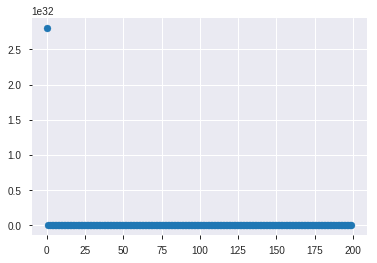

In [457]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

## Feature Scaling / Standardization

## Goal 5

Notes: Aaron Gallant just said this was not relevant to be done here...so I will not put too much time into applying this here...

In [0]:
'''import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['SALE_PRICE'] = boston.target
df.head(3)
'''

In [0]:
df.shape

In [0]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('SALE_PRICE', axis='columns')
y = df.SALE_PRICE

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))